In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
np.random.seed(11) # previous used 11, 12, 13

In [2]:
d = 10
N = 10
ws = []
for i in range(N):
    ws.append(np.random.multivariate_normal(np.zeros(d), np.eye(d), 1))
W = np.vstack(ws)

In [3]:
def empirical_covariance(X):
    n = X.shape[0]
    S = 0.
    for i in range(n):
        S += np.outer(X[i, :], X[i, :])
    S = S / float(n)
    return S

In [4]:
def estimate_covariance(X, nu=0.0, norm=1):
    d = X.shape[1]
    n = X.shape[0]
    rhat = cp.Variable((d, d), PSD=True)
    
    obj = 0
    for i in range(n):
        xi = X[i, :]
        obj += (cp.quad_form(xi, rhat) + d*np.log(2*np.pi) - cp.log_det(rhat))
    obj = obj / 2.0
    if nu > 0:
        obj += nu*cp.norm(rhat, norm)
    p = cp.Problem(cp.Minimize(obj), [])
    p.solve()
    return np.linalg.inv(rhat.value)

In [5]:
import scipy as sp
import scipy.stats
import math

# Compute log likelihood of test set
def likelihood(X, mean, S):
    l = 0
    R = np.linalg.inv(S)
    for i in range(X.shape[0]):
        x = X[i, :]
        l += -1. * np.matmul((x - mean).T, np.matmul(R, (x - mean))) - X.shape[1] * np.log(2*np.pi) + np.log(np.linalg.det(R))
        
    l = l / (2*X.shape[0])
    return l

In [6]:
def impute(S, xmatch, K):
    xhat = cp.Variable(S.shape[0])
    R = np.linalg.inv(S)
    obj = cp.quad_form(xhat, R)
    constraints = []
    for k in K:
        constraints.append(xhat[k] == xmatch[k])
    p = cp.Problem(cp.Minimize(obj), constraints)
    p.solve()
    return xhat.value

In [7]:
def ints_without(k, hi):
    out = []
    for i in range(hi):
        if i != k:
            out.append(i)
    return out

In [8]:
def impute_err(X, S):
    allerrs = []
    for i in range(X.shape[0]):
        x = X[i, :]
        errs = []
        for j in range(X.shape[1]):
            err = x[j] - impute(S, x, ints_without(j, X.shape[1]))[j]
            errs.append(err)
        errs = np.array(errs)
        allerrs.append(np.mean(np.abs(errs)))
    return np.mean(allerrs)

In [9]:
def impute_err2(X, S):
    allerrs = []
    for i in range(X.shape[0]):
        x = X[i, :]
        errs = []
        for j in range(X.shape[1]):
            err = x[j] - impute(S, x, ints_without(j, X.shape[1]))
            errs.append(err)
        errs = np.array(errs)
        allerrs.append(np.mean(np.abs(errs)))
    return np.mean(allerrs)

In [10]:
np.random.permutation(np.arange(5))[:3]

array([4, 0, 1])

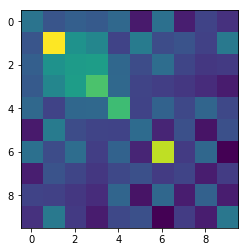

In [11]:
F = np.random.rand(d, d)
X = np.matmul(F, W.T).T
Sigma = np.matmul(F, F.T)
plt.imshow(Sigma)

In [12]:
Xtrain = X[:8, :]
Xtest = X[8:, :]

In [13]:
lambdas = [0.0, 0.01, 0.1, 1, 10, 100]

In [14]:
estimates = [estimate_covariance(Xtrain, nu=lamb, norm=1) for lamb in lambdas]

In [15]:
froestimates = [estimate_covariance(Xtrain, nu=lamb, norm=2) for lamb in lambdas]

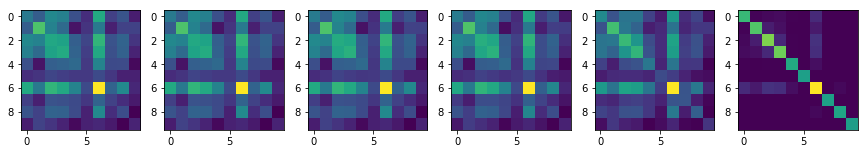

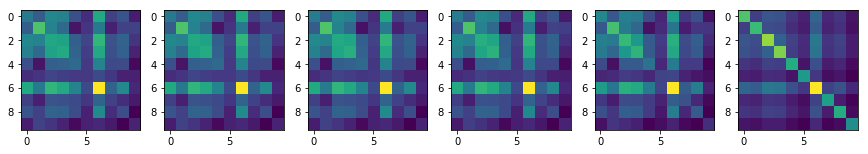

In [16]:
fig, ax = plt.subplots(1, len(estimates), figsize=(15, 15))
for (i, S) in enumerate(estimates):
    ax[i].imshow(S)
    
fig, ax = plt.subplots(1, len(froestimates), figsize=(15, 15))
for (i, S) in enumerate(froestimates):
    ax[i].imshow(S)

Minimum l1 is lambda = 1 at 13.339452334205351
Minimum l2 is lambda = 10 at 12.879503788193388
Frobenius error of sample covariance matrix 13.209115869709285


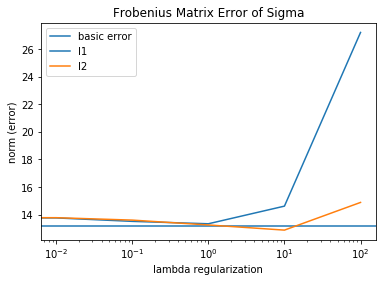

In [17]:
l1sigmaerrs = [np.linalg.norm(S - Sigma) for S in estimates]
l2sigmaerrs = [np.linalg.norm(S - Sigma) for S in froestimates]
plt.xscale('log')
print(f"Minimum l1 is lambda = {lambdas[np.argmin(l1sigmaerrs)]} at {np.min(l1sigmaerrs)}")
print(f"Minimum l2 is lambda = {lambdas[np.argmin(l2sigmaerrs)]} at {np.min(l2sigmaerrs)}")
plt.title("Frobenius Matrix Error of Sigma")
plt.xlabel("lambda regularization")
plt.ylabel("norm (error)")
SampleSigma = empirical_covariance(Xtrain)
SampleSigmaErr = np.linalg.norm(Sigma - SampleSigma)
print(f"Frobenius error of sample covariance matrix {SampleSigmaErr}")
plt.axhline(y=SampleSigmaErr, label="basic error")
plt.plot(lambdas, l1sigmaerrs, label="l1")
plt.plot(lambdas, l2sigmaerrs, label="l2")
plt.legend()

In [18]:
train_likelihoods = [likelihood(Xtrain, np.zeros(10), S) for S in estimates]
test_likelihoods = [likelihood(Xtest, np.zeros(10), S) for S in estimates]

Maximum l1 is lambda = 0.0
Maximum l2 is lambda = 1


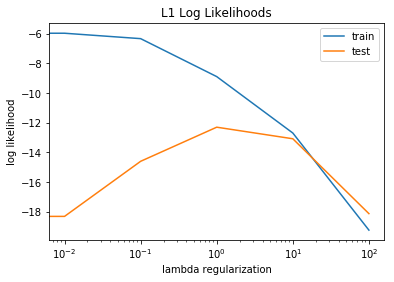

In [19]:
plt.plot(lambdas, train_likelihoods, label="train")
plt.plot(lambdas, test_likelihoods, label="test")
plt.xscale('log')
plt.title("L1 Log Likelihoods")
plt.legend()
plt.ylabel("log likelihood")
plt.xlabel("lambda regularization")
print(f"Maximum l1 is lambda = {lambdas[np.argmax(train_likelihoods)]}")
print(f"Maximum l2 is lambda = {lambdas[np.argmax(test_likelihoods)]}")

In [20]:
train_imputation_errs = [impute_err(Xtrain, S) for S in estimates]
test_imputation_errs = [impute_err(Xtest, S) for S in estimates]

Minimum TRAIN l1 is lambda = 0.0
Minimum TEST l1 is lambda = 0.0


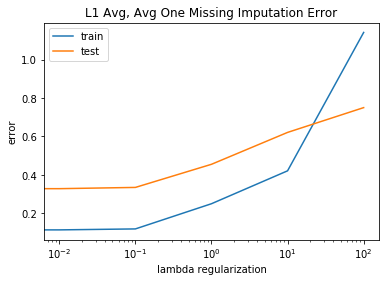

In [21]:
plt.plot(lambdas, train_imputation_errs, label="train")
plt.plot(lambdas, test_imputation_errs, label="test")
plt.xscale('log')
plt.legend()
plt.title("L1 Avg, Avg One Missing Imputation Error")
plt.xlabel("lambda regularization")
plt.ylabel("error")
print(f"Minimum TRAIN l1 is lambda = {lambdas[np.argmin(train_imputation_errs)]}")
print(f"Minimum TEST l1 is lambda = {lambdas[np.argmin(test_imputation_errs)]}")

In [22]:
frotrain_likelihoods = [likelihood(Xtrain, np.zeros(10), S) for S in froestimates]
frotest_likelihoods = [likelihood(Xtest, np.zeros(10), S) for S in froestimates]

Maximum l1 is lambda = 0.0
Maximum l2 is lambda = 1


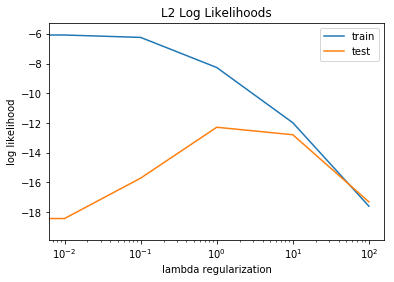

In [23]:
plt.plot(lambdas, frotrain_likelihoods, label="train")
plt.plot(lambdas, frotest_likelihoods, label="test")
plt.xscale('log')
plt.title("L2 Log Likelihoods")
plt.legend()
plt.ylabel("log likelihood")
plt.xlabel("lambda regularization")
print(f"Maximum l1 is lambda = {lambdas[np.argmax(frotrain_likelihoods)]}")
print(f"Maximum l2 is lambda = {lambdas[np.argmax(frotest_likelihoods)]}")

In [24]:
frotrain_imputation_errs = [impute_err(Xtrain, S) for S in froestimates]
frotest_imputation_errs = [impute_err(Xtest, S) for S in froestimates]

Minimum TRAIN l2 is lambda = 0.0
Minimum TEST l2 is lambda = 0.0


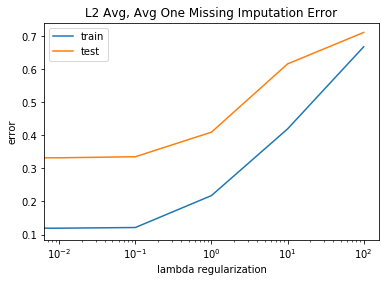

In [25]:
plt.plot(lambdas, frotrain_imputation_errs, label="train")
plt.plot(lambdas, frotest_imputation_errs, label="test")
plt.xscale('log')
plt.legend()
plt.title("L2 Avg, Avg One Missing Imputation Error")
plt.xlabel("lambda regularization")
plt.ylabel("error")
print(f"Minimum TRAIN l2 is lambda = {lambdas[np.argmin(frotrain_imputation_errs)]}")
print(f"Minimum TEST l2 is lambda = {lambdas[np.argmin(frotest_imputation_errs)]}")

---

---

---

---

In [26]:
def featurize(x, features):
    assert len(features) >= 1
    return np.concatenate([[f(y) for f in features] for y in x])

def featurize_dataset(X, features):
    return np.stack([featurize(X[i, :], features) for i in range(X.shape[0])])

In [27]:
polynomial_features = [
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3,
    lambda x: x**4,
    lambda x: x**5,
    lambda x: x**6,
    lambda x: x**7,
]

In [28]:
LiftedXs = [featurize_dataset(X, polynomial_features[:i]) for i in range(1, len(polynomial_features)+1)]

In [29]:
Sigmas = [empirical_covariance(Xset[:80, :]) for Xset in LiftedXs]

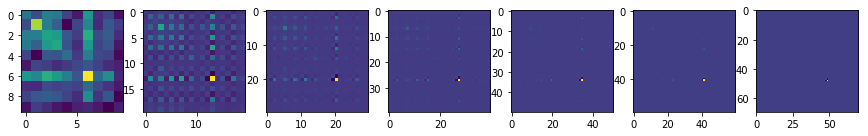

In [30]:
fig, ax = plt.subplots(1, len(polynomial_features), figsize=(15, 15))
for (a, S) in zip(ax, Sigmas):
    a.imshow(S)

In [37]:
iss = [0, 1,2, 4]
xs = []
for i in iss:
    for j in iss:
        xs.append((i, j))

In [38]:
Z = np.random.rand(5, 5)

In [39]:
Z

array([[0.58743422, 0.44075398, 0.25036821, 0.33048211, 0.64291927],
       [0.28402159, 0.34619571, 0.35410263, 0.32480587, 0.82853017],
       [0.54578534, 0.01836989, 0.74157863, 0.50216978, 0.77889323],
       [0.49456364, 0.31083775, 0.83928841, 0.17334502, 0.27827657],
       [0.48414788, 0.85987119, 0.11521202, 0.33868847, 0.53224018]])

In [40]:
Z[iss, ]

array([0.58743422, 0.34619571, 0.74157863, 0.53224018])